In [ ]:
v3_full_model.save_weights('inceptionv3_b32_bestweights.hdf5')
resnet152_full_model.save_weights('resnet152_b32_bestweights.hdf5')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation, Flatten, Dense, BatchNormalization, ZeroPadding2D
from keras.optimizers import Adam
from keras import backend as k
import tensorflow as tf

import os
import shutil

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/MyDrive/Science Fair/Synopsis Science Fair Project 2021/Dataset_-20210215T213906Z-001.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_/COVID-19/COVID (131).png  
  inflating: Dataset_/COVID-19/COVID (562).png  
  inflating: Dataset_/COVID-19/COVID (627).png  
  inflating: Dataset_/COVID-19/COVID (522).png  
  inflating: Dataset_/COVID-19/COVID (236).png  
  inflating: Dataset_/COVID-19/COVID (174).png  
  inflating: Dataset_/COVID-19/COVID (260).png  
  inflating: Dataset_/COVID-19/COVID (2).png  
  inflating: Dataset_/COVID-19/COVID (165).png  
  inflating: Dataset_/COVID-19/COVID (303).png  
  inflating: Dataset_/COVID-19/COVID (149).png  
  inflating: Dataset_/COVID-19/COVID (16).png  
  inflating: Dataset_/COVID-19/COVID (404).png  
  inflating: Dataset_/COVID-19/COVID (42).png  
  inflating: Dataset_/COVID-19/COVID (38).png  
  inflating: Dataset_/COVID-19/COVID (497).png  
  inflating: Dataset_/COVID-19/COVID (466).png  
  inflating: Dataset_/COVID-19/COVID (469).png  
  inflating: Dataset_/COVID-19/COVID (571).png  
  inflating: Dataset_/C

In [ ]:
# Creates a folder for training and testing sets
!mkdir test
!mkdir train
!mkdir "train/Non-COVID Viral Pneumonia"
!mkdir "train/COVID-19"
!mkdir "train/Normal"
!mkdir "train/Bacterial Pneumonia"
!mkdir "test/Non-COVID Viral Pneumonia"
!mkdir "test/COVID-19"
!mkdir "test/Normal"
!mkdir "test/Bacterial Pneumonia"

In [ ]:
# Divide files into training and testing folders
# IMG_PATH = 'covid19dataset/' # unzipped folder
IMG_PATH = 'Dataset_/' # unzipped folder

print(IMG_PATH)
import os, shutil
# split the data by train/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
      dir  = os.path.isdir(IMG_PATH + CLASS)
      if dir:
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.8*IMG_NUM:
                shutil.copy(img, 'train/' + CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'test/'+ CLASS + '/' + FILE_NAME)

Dataset_/


In [ ]:
# dimensions of our images
img_width, img_height = 224, 224
img_size = (224, 224)

# Saving the batch_size and epochs for training to variables
batch_size = 64 #usually in powers of 2 - 8, 16, 32, 64, 128
epochs = 50
lr = 0.0001
class_array = ['Normal', 'COVID-19', 'Non-COVID Viral Pneumonia']
num_classes = len(class_array)

train_file_count = sum(len(files) for _, _, files in os.walk(r'train'))
test_file_count = sum(len(files) for _, _, files in os.walk(r'test'))

print("Number of files in train set ", train_file_count)
print("Number of files in test set ", test_file_count)

Number of files in train set  6744
Number of files in test set  1684


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, #normalization
                                   validation_split=0.15,
                                   shear_range = 0.2, # extent of shearing - 20%
                                   zoom_range = 0.2, # extent of adjusting the zoom in images - 20%
                                   horizontal_flip= True, # randomly flipping to get mirror images
                                   rotation_range=0.1)

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15)

In [ ]:
# Create a flow from the directory using same seed and 'training' subset.
train_generator = train_datagen.flow_from_directory('train',
                                              subset='training',
                                              shuffle=True,
                                              seed=42,
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              classes = class_array)

# Create a flow from the directory for validation data - seed=42
validation_generator = valid_datagen.flow_from_directory('train',
                                              subset='validation',
                                              seed=42,
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              classes = class_array)

Found 4136 images belonging to 3 classes.
Found 728 images belonging to 3 classes.


###Inception v3

In [ ]:
from keras.applications.inception_v3 import InceptionV3

v3_pre_trained_model = InceptionV3(input_shape = (224,224,3),
                                include_top = False,
                                weights = 'imagenet')

for layer in v3_pre_trained_model.layers:
    layer.trainable = False

v3_pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
def build_my_model(model_name):

    new_model = Sequential()
    model = model_name
    new_model.add(model)
    new_model.add(Flatten())
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(num_classes, activation='softmax'))
    return new_model

my_v3_model = build_my_model(v3_pre_trained_model)

my_v3_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              52429824  
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)              

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

optimizer = Adam(lr = lr) # RMSprop(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

weight_path = "inceptionv3_b64_bestweights.hdf5".format('class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss',
                      mode= 'auto',
                      patience=10)

callbacks_list = [checkpoint, early]


my_v3_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = my_v3_model.fit(train_generator,
                          validation_data = validation_generator,
                          batch_size = batch_size,
                          epochs = epochs,
                          callbacks = callbacks_list)

Epoch 1/50
65/65 [==============================] - 120s 2s/step - loss: 1.2350 - accuracy: 0.6617 - val_loss: 0.2496 - val_accuracy: 0.9066

Epoch 00001: val_loss improved from inf to 0.24960, saving model to inceptionv3_b64_bestweights.hdf5
Epoch 2/50
65/65 [==============================] - 115s 2s/step - loss: 0.3118 - accuracy: 0.8872 - val_loss: 0.2138 - val_accuracy: 0.9245

Epoch 00002: val_loss improved from 0.24960 to 0.21380, saving model to inceptionv3_b64_bestweights.hdf5
Epoch 3/50
65/65 [==============================] - 109s 2s/step - loss: 0.2618 - accuracy: 0.9037 - val_loss: 0.2122 - val_accuracy: 0.9231

Epoch 00003: val_loss improved from 0.21380 to 0.21225, saving model to inceptionv3_b64_bestweights.hdf5
Epoch 4/50
65/65 [==============================] - 109s 2s/step - loss: 0.2302 - accuracy: 0.9067 - val_loss: 0.3289 - val_accuracy: 0.8832

Epoch 00004: val_loss did not improve from 0.21225
Epoch 5/50
65/65 [==============================] - 111s 2s/step - los

In [ ]:
Inception_model_json = my_v3_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(Inception_model_json)

# serialize weights to HDF5
my_v3_model.save_weights("model.h5")
print("Saved model to disk")

# save model and architecture to single file
my_v3_model.save("inception_v3_b16.h5")
print("Saved full model to disk")

Saved model to disk
Saved full model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


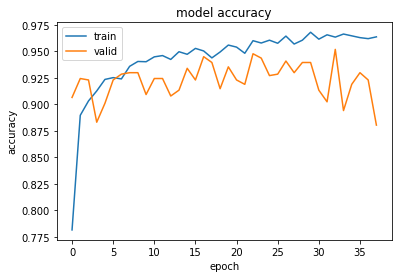

In [ ]:
print(history.history.keys()) # prints what the history has stored (stored in a dictionary format (key-value pairs))

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

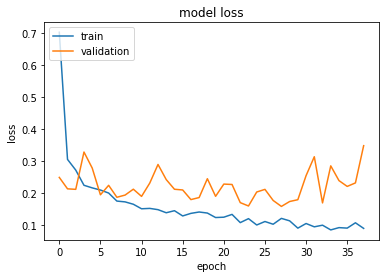

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from keras.models import load_model #to load the model saved as a h5 file
# load model
v3_full_model = build_my_model(v3_pre_trained_model)

v3_full_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

v3_full_model.load_weights('inceptionv3_b64_bestweights.hdf5')
# summarize model.
v3_full_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              52429824  
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory('test',
                                              target_size= (224,224),
                                              batch_size = 1,
                                              shuffle = False,
                                              class_mode='categorical',
                                              classes = class_array)


my_v3_model.evaluate(test_generator)

Found 1214 images belonging to 3 classes.
1214/1214 [==============================] - 41s 33ms/step - loss: 0.2763 - accuracy: 0.9127


[0.27632567286491394, 0.9126853346824646]

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       462
           1       0.97      0.98      0.98       258
           2       0.98      0.82      0.89       494

    accuracy                           0.91      1214
   macro avg       0.93      0.92      0.92      1214
weighted avg       0.92      0.91      0.91      1214

accuracy:  0.9126853377265239
[[452   5   5]
 [  2 253   3]
 [ 89   2 403]]


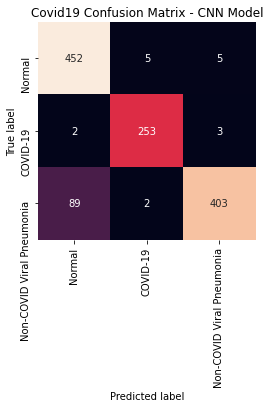

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
y_true = test_generator.classes
probabilities = my_v3_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1214/1214 [==============================] - 42s 33ms/step - loss: 0.1506 - accuracy: 0.9461
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       462
           1       0.98      0.95      0.96       258
           2       0.93      0.97      0.95       494

    accuracy                           0.95      1214
   macro avg       0.95      0.95      0.95      1214
weighted avg       0.95      0.95      0.95      1214

accuracy:  0.9497528830313015
[[428   5  29]
 [  4 246   8]
 [ 14   1 479]]


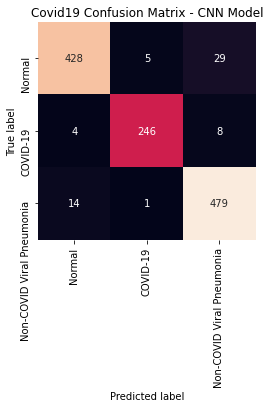

In [ ]:
v3_full_model.evaluate(test_generator)

from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
y_true = test_generator.classes
probabilities = v3_full_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###ResNet152

In [ ]:
from keras.applications.resnet import ResNet152

ResNet152_pre_trained_model = ResNet152(input_shape = (224,224,3),
                                include_top = False,
                                weights = 'imagenet')

for layer in ResNet152_pre_trained_model.layers:
    layer.trainable = False

ResNet152_pre_trained_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
from keras.models import Sequential, Model

def build_my_model(model_name):

    new_model = Sequential()
    model = model_name
    new_model.add(model)
    new_model.add(Flatten())
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(num_classes, activation='softmax'))
    return new_model

my_resnet152_model = build_my_model(ResNet152_pre_trained_model)

my_resnet152_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              102761472 
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)              

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

optimizer = Adam(lr = lr) # RMSprop(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

weight_path="resnet152_b64_bestweights.hdf5".format('class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor= 'val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode= 'auto',
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss',
                      mode= 'auto',
                      patience=10)

callbacks_list = [checkpoint, early]


my_resnet152_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = my_resnet152_model.fit(train_generator,
                          validation_data = validation_generator,
                          epochs = epochs,
                          batch_size = batch_size,
                          callbacks = callbacks_list)

Epoch 1/50
65/65 [==============================] - 124s 2s/step - loss: 1.3619 - accuracy: 0.4143 - val_loss: 0.7835 - val_accuracy: 0.5701

Epoch 00001: val_loss improved from inf to 0.78348, saving model to resnet152_b64_bestweights.hdf5
Epoch 2/50
65/65 [==============================] - 110s 2s/step - loss: 0.8384 - accuracy: 0.5886 - val_loss: 0.7768 - val_accuracy: 0.6030

Epoch 00002: val_loss improved from 0.78348 to 0.77678, saving model to resnet152_b64_bestweights.hdf5
Epoch 3/50
65/65 [==============================] - 112s 2s/step - loss: 0.7638 - accuracy: 0.6333 - val_loss: 0.5962 - val_accuracy: 0.7335

Epoch 00003: val_loss improved from 0.77678 to 0.59616, saving model to resnet152_b64_bestweights.hdf5
Epoch 4/50
65/65 [==============================] - 111s 2s/step - loss: 0.6564 - accuracy: 0.7194 - val_loss: 0.5120 - val_accuracy: 0.7926

Epoch 00004: val_loss improved from 0.59616 to 0.51197, saving model to resnet152_b64_bestweights.hdf5
Epoch 5/50
65/65 [======

In [ ]:
ResNet152_model_json = my_resnet152_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(ResNet152_model_json)

# serialize weights to HDF5
my_resnet152_model.save_weights("model.h5")
print("Saved model to disk")

# save model and architecture to single file
my_resnet152_model.save("resnet152.h5")
print("Saved full model to disk")

Saved model to disk
Saved full model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


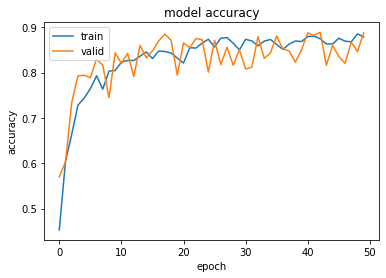

In [ ]:
print(history.history.keys()) # prints what the history has stored (stored in a dictionary format (key-value pairs))

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

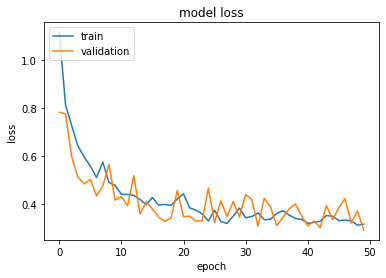

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from keras.models import load_model #to load the model saved as a h5 file
# load model
resnet152_full_model = build_my_model(ResNet152_pre_trained_model)

resnet152_full_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

resnet152_full_model.load_weights('resnet152_b64_bestweights.hdf5')
# summarize model.
resnet152_full_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
flatten_7 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              102761472 
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)              

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory('test',
                                              target_size= (224,224),
                                              batch_size = 1,
                                              shuffle = False,
                                              class_mode='categorical',
                                              classes = class_array)

my_resnet152_model.evaluate(test_generator)

Found 1214 images belonging to 3 classes.
1214/1214 [==============================] - 49s 40ms/step - loss: 0.2610 - accuracy: 0.9168


[0.2610079050064087, 0.9168039560317993]

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       462
           1       0.94      0.93      0.94       258
           2       0.93      0.89      0.91       494

    accuracy                           0.92      1214
   macro avg       0.92      0.92      0.92      1214
weighted avg       0.92      0.92      0.92      1214

accuracy:  0.9168039538714992
[[433   6  23]
 [ 10 239   9]
 [ 45   8 441]]


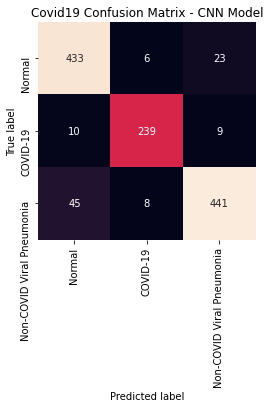

In [ ]:
y_true = test_generator.classes
probabilities = my_resnet152_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1214/1214 [==============================] - 51s 39ms/step - loss: 0.2211 - accuracy: 0.9398
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       462
           1       0.94      0.93      0.94       258
           2       0.93      0.89      0.91       494

    accuracy                           0.92      1214
   macro avg       0.92      0.92      0.92      1214
weighted avg       0.92      0.92      0.92      1214

accuracy:  0.9168039538714992
[[433   6  23]
 [ 10 239   9]
 [ 45   8 441]]


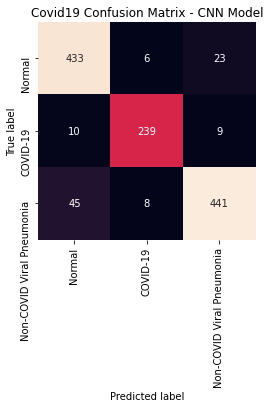

In [ ]:
resnet152_full_model.evaluate(test_generator)

y_true = test_generator.classes
probabilities = resnet152_full_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
!cp resnet152_b64_bestweights.hdf5 "/content/gdrive/MyDrive/Science Fair"
!cp inceptionv3_b64_bestweights.hdf5 "/content/gdrive/MyDrive/Science Fair"

!cp resnet152_b64_bestweights.hdf5 "/content/gdrive/MyDrive/Science Fair"
!cp inceptionv3_b64_bestweights.hdf5 "/content/gdrive/MyDrive/Science Fair"